# 이진 분류(Binary Classification)
### 개와 고양이 사진 분류하기
---

### 필요한 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 데이터셋 구축
```
dataset
├─ train
│  ├─ cats
│  └─ dogs
├─ val
│  ├─ cats
│  └─ dogs
└─ test
    ├─ cats
    └─ dogs
```

In [ ]:
# !wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [ ]:
# !unzip cats_and_dogs_filtered.zip

In [ ]:
import os

data_root = '/content/cats_and_dogs_filtered'
data_root

'/content/cats_and_dogs_filtered'

In [ ]:
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'validation')

In [ ]:
train_cats_fname = os.listdir(os.path.join(train_dir, 'cats'))
train_dogs_fname = os.listdir(os.path.join(train_dir, 'dogs'))

print('cats:', len(train_cats_fname))
print('dogs:', len(train_dogs_fname))

cats: 1000
dogs: 1000


In [ ]:
class_name = ['cat', 'dog']

### 학습용 데이터

In [ ]:
import PIL
from tqdm import tqdm

X_train = []
y_train = []

for i in tqdm(range(len(train_cats_fname))):
    f = os.path.join(train_dir, 'cats', train_cats_fname[i])
    image = PIL.Image.open(f)
    image = image.resize((224, 224))
    arr = np.array(image)
    X_train.append(arr)
    y_train.append(0)

100%|██████████| 1000/1000 [00:04<00:00, 211.15it/s]


In [ ]:
for i in tqdm(range(len(train_dogs_fname))):
    f = os.path.join(train_dir, 'dogs', train_dogs_fname[i])
    image = PIL.Image.open(f)
    image = image.resize((224, 224))
    arr = np.array(image)
    X_train.append(arr)
    y_train.append(1)

100%|██████████| 1000/1000 [00:11<00:00, 83.47it/s]


### 검증용 데이터

In [ ]:
val_cats_fname = os.listdir(os.path.join(val_dir, 'cats'))
val_dogs_fname = os.listdir(os.path.join(val_dir, 'dogs'))

print('cats:', len(val_cats_fname))
print('dogs:', len(val_dogs_fname))

cats: 500
dogs: 500


In [ ]:
X_val = []
y_val = []

for i in tqdm(range(len(val_cats_fname))):
    f = os.path.join(val_dir, 'cats', val_cats_fname[i])
    image = PIL.Image.open(f)
    image = image.resize((224, 224))
    arr = np.array(image)
    X_val.append(arr)
    y_val.append(0)

for i in tqdm(range(len(val_dogs_fname))):
    f = os.path.join(val_dir, 'dogs', val_dogs_fname[i])
    image = PIL.Image.open(f)
    image = image.resize((224, 224))
    arr = np.array(image)
    X_val.append(arr)
    y_val.append(1)

100%|██████████| 500/500 [00:02<00:00, 181.20it/s]


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2000, 224, 224, 3) (2000,)
(1000, 224, 224, 3) (1000,)


In [ ]:
from sklearn.model_selection import train_test_split


X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, 
                                                test_size=0.2, 
                                                shuffle=True, 
                                                random_state=1234)

print(X_val.shape, X_test.shape)
print(y_val.shape, y_test.shape)

(800, 224, 224, 3) (200, 224, 224, 3)
(800,) (200,)


- 정규화: Min-Max Scaler

In [ ]:
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [ ]:
X_train.shape

(2000, 224, 224, 3)

### 모델링(Modeling)

In [ ]:
model = keras.Sequential([
    layers.Conv2D(16, 3, input_shape=(224, 224, 3)), 
    layers.BatchNormalization(), 
    layers.ReLU(), 
    layers.MaxPool2D(2), 

    layers.Conv2D(32, 3), 
    layers.BatchNormalization(), 
    layers.ReLU(), 
    layers.MaxPool2D(2), 

    layers.Conv2D(64, 3), 
    layers.BatchNormalization(), 
    layers.ReLU(), 
    layers.MaxPool2D(2), 

    layers.Flatten(), 
    layers.Dense(32, activation='relu'), 
    layers.Dropout(0.3), 
    layers.Dense(16, activation='relu'), 
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 32)     1

### 컴파일(Compile)

In [ ]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['acc']
)

### 학습(Training)
- 콜백(callbacks)

In [ ]:
from tensorflow.keras import callbacks

ckpt_path = 'cats_and_dogs.ckpt'

ckpt_callback = callbacks.ModelCheckpoint(
    ckpt_path, 
    monitor='val_loss', 
    save_weights_only=True, 
    save_best_only=True, 
    verbose=1
)

es_callback = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5
)

In [ ]:
%%time
EPOCHS = 30
BATCH_SIZE = 32

history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_val, y_val), 
                    callbacks=[ckpt_callback, es_callback], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 1.1213 - acc: 0.5305
Epoch 1: val_loss improved from inf to 0.69198, saving model to cats_and_dogs.ckpt
63/63 [==============================] - 19s 74ms/step - loss: 1.1213 - acc: 0.5305 - val_loss: 0.6920 - val_acc: 0.5375
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.6661 - acc: 0.5925
Epoch 2: val_loss did not improve from 0.69198
63/63 [==============================] - 3s 47ms/step - loss: 0.6661 - acc: 0.5925 - val_loss: 0.6940 - val_acc: 0.4988
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.6554 - acc: 0.5990
Epoch 3: val_loss did not improve from 0.69198
63/63 [==============================] - 3s 50ms/step - loss: 0.6554 - acc: 0.5990 - val_loss: 0.6948 - val_acc: 0.5013
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 0.6551 - acc: 0.6060
Epoch 4: val_loss did not improve from 0.69198
63/63 [==============================] - 3s 50ms/step - los

- 학습 과정 시각화

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'],label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'],label = 'Val Accuracy')

    plt.legend()
    plt.show()

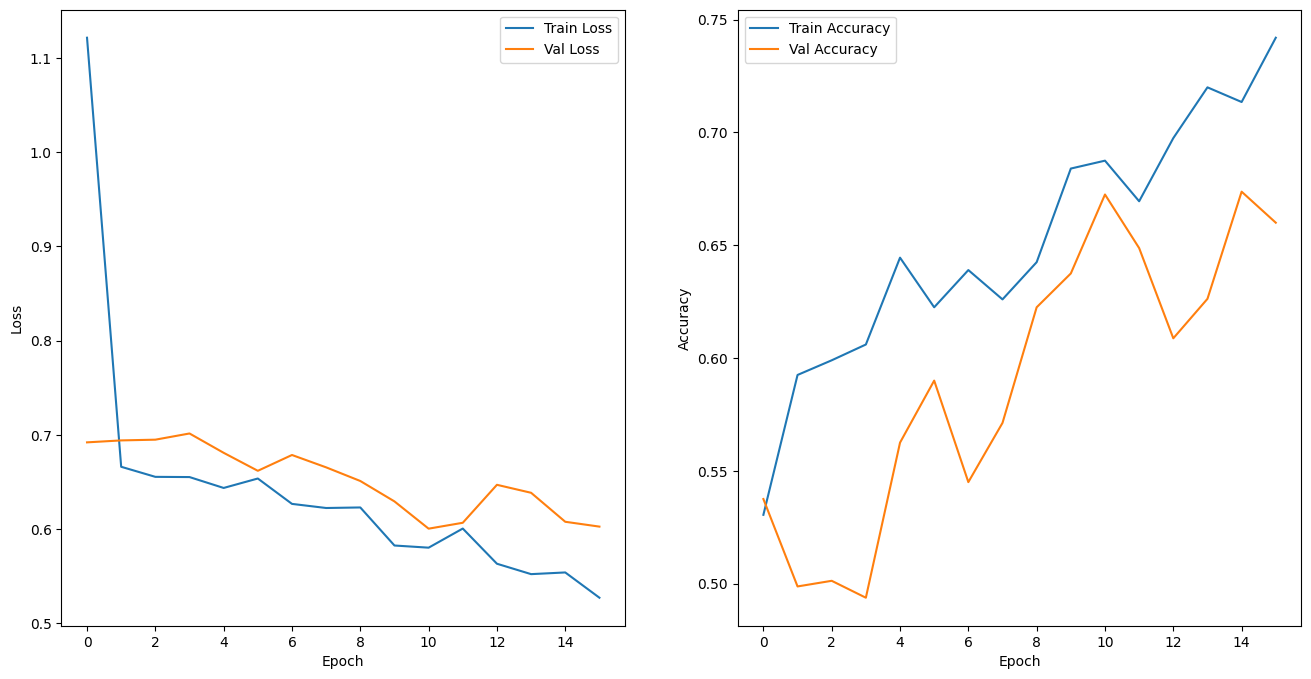

In [ ]:
plot_history(history)

### 평가(Evaluation)

In [ ]:
model.load_weights(ckpt_path)

In [ ]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 42ms/step - loss: 0.5772 - acc: 0.7300


[0.5772245526313782, 0.7300000190734863]

### 예측(Prediction)

In [ ]:
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 15ms/step


In [ ]:
y_pred.shape

(200, 1)

In [ ]:
y_test.shape

(200,)

In [ ]:
y_pred = y_pred.flatten()
y_pred = (y_pred>0.5).astype('int')
y_pred[:5]

array([0, 1, 0, 1, 0])

- 혼동 행렬(confusion matrix)

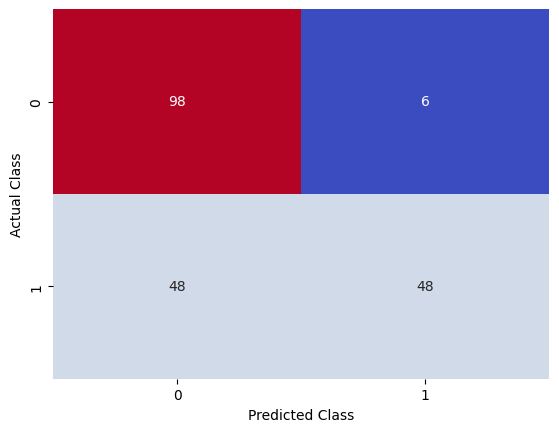

In [ ]:
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, cbar=False, cmap='coolwarm', fmt='d')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()